In [17]:
import numpy as np
import pandas as pd
import tensorflow 
X = pd.read_csv('./creditcard.csv', na_filter=True)

y_original = np.array(X['Class'], dtype='float')

X.drop(['Class'], inplace=True, axis=1)

rolling_window_size = 10  ### this selects how many historical transactions should be analyzed to judge the transaction at hand -- RNN width

X_interim = np.zeros([(X.shape[0]-rolling_window_size)*10,30])
y = []
for i in range((X.shape[0]-rolling_window_size)):
    beg = 0+i
    end = beg+rolling_window_size
    s = np.array(X[beg:end], dtype='float')
    X_interim[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    y.append(y_original[end])
    
 
y = np.array(y, dtype='float')
X_interim = X_interim[:,1::]
X_tensor = X_interim.reshape((np.shape(X_interim)[0]//rolling_window_size), rolling_window_size, np.shape(X_interim)[1])
y


array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
X_tensor.shape

NameError: name 'X_tensor' is not defined

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

test_train_split = 0.5
stratify = True

if stratify:
    y = np.vstack((range(len(y)),y)).T
    y_pos = y[y[:,1]==1]
    y_neg = y[y[:,1]==0]
    
    y_pos = y_pos[np.random.choice(y_pos.shape[0], int(y_pos.shape[0]*test_train_split), replace=False),:]
    y_neg = y_neg[np.random.choice(y_neg.shape[0], int(y_neg.shape[0]*test_train_split), replace=False),:]
    
    train_idx = np.array(np.hstack((y_pos[:,0],y_neg[:,0])), dtype='int')
    
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx,1]
    y_test = np.delete(y, train_idx, axis=0)
    y_test = y_test[:,1]
else: 
    train_idx = np.random.choice(X_tensor.shape[0], int(X_tensor.shape[0]*test_train_split), replace=False)
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx]
    y_test = np.delete(y, train_idx, axis=0)

del (X_tensor, y, stratify, test_train_split, train_idx, y_neg, y_pos)


### Hyperparameters Tuning
# First test optimal epochs holding everything else constant
# Dropout: 0.1-0.6
# GradientClipping: 0.1-10
# BatchSize: 32,64,128,256,512 (power of 2)


### Train LSTM using Keras 2 API ###
model = Sequential()
model.add(LSTM(20, input_shape=X_train.shape[1:], kernel_initializer='lecun_uniform', activation='relu', bias_regularizer=None, activity_regularizer=None, dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))
#model.add(LSTM(12, activation='relu', return_sequences=True))
#model.add(LSTM(8, activation='relu'))
model.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #optimizer='rmsprop'
print(model.summary())

model.fit(X_train, y_train, epochs=50, batch_size=10000, class_weight={0 : 1., 1: float(int(1/np.mean(y_train)))}, validation_split=0.3)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                4000      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
10/10 [==============================] - 4s 246ms/step - loss: 18.3718 - accuracy: 0.6355 - val_loss: 2.7864 - val_accuracy: 0.5253
Epoch 2/50
10/10 [==============================] - 2s 214ms/step - loss: 25.7602 - accuracy: 0.5942 - val_loss: 2.7581 - val_accuracy: 0.4884
Epoch 3/50
10/10 [==============================] - 2s 211ms/step - loss: 9.4440 - accuracy: 0.5518 - val_loss: 2.5333 - val_accuracy: 0.4629
Epoch 4/50
10/10 [==============================] - 2s 211ms/step - loss: 8.3691 

In [19]:
### test AUC ###
from sklearn import metrics 

fpr, tpr, thresholds = metrics.roc_curve(y_train, train_predict, pos_label=1)
print('TRAIN | AUC Score: ' + str((metrics.auc(fpr, tpr))))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predict, pos_label=1)
print('TEST | AUC Score: ' + str((metrics.auc(fpr, tpr))))

TRAIN | AUC Score: 0.6391376063959019
TEST | AUC Score: 0.5927647006240099


In [53]:
X1

,0,test_predict,outlier
0,0.0,0.525307,NaN
1,0.0,0.629138,NaN
2,0.0,0.568565,NaN
3,0.0,0.524333,NaN
4,0.0,0.525083,NaN
...,...,...,...
142394,0.0,0.517989,NaN
142395,0.0,0.817784,1.0
142396,0.0,0.593798,NaN
142397,0.0,0.547244,NaN


In [55]:
print('Threshold: ',np.quantile(test_predict,0.6))
threshold =np.quantile(test_predict,0.6)
X1 = pd.DataFrame(np.zeros(142399,))
X1['test_predict'] = test_predict
X1.loc[X1['test_predict'].values > threshold,'outlier'] = 1
X1.loc[X1['test_predict'].values <= threshold,'outlier'] = 0
metrics.confusion_matrix(y_test, X1['outlier'].values)

Threshold:  0.5605366110801697


array([[85320, 56833],
       [  119,   127]], dtype=int64)

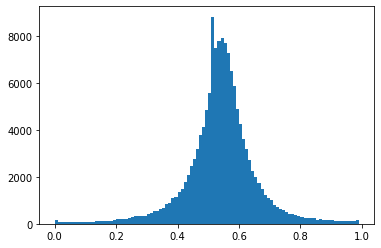

In [35]:
import matplotlib.pyplot as plt
bins = np.arange(0, 1, 0.01)
plt.hist(test_predict,bins=bins)
plt.show()